Excercise 1

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import sys
import os
from scipy.signal import butter, filtfilt
sys.path.append(os.path.abspath("code"))
from utils import download_data
import lfp_functions as lf

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False,
                     'image.cmap':plt.cm.jet})

In [2]:
# Download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/7BosHgemAseANIc')

In [3]:
with open('data/moving_lfp.pickle', "rb") as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')


Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


In [5]:
signal = lfp 
fs = 1000
time = np.linspace(0, len(signal)/fs, len(signal))


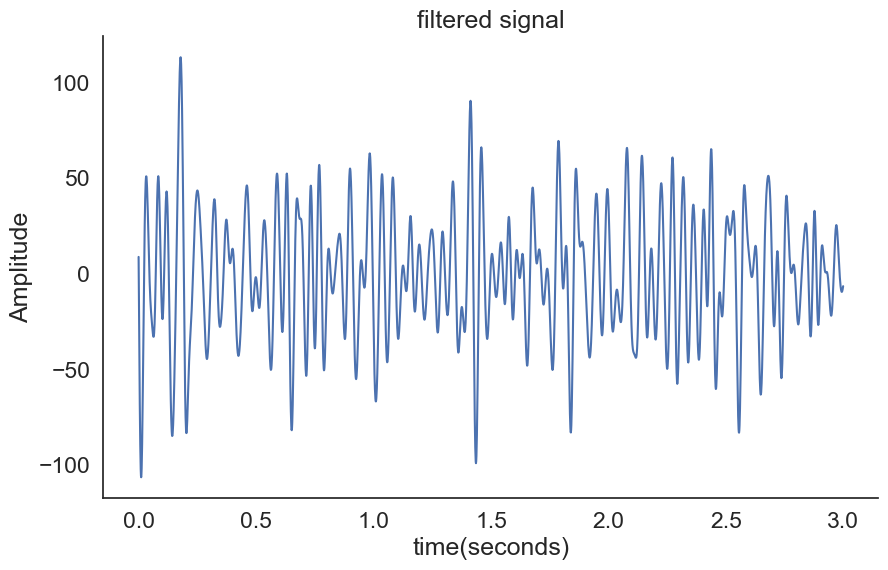

In [6]:
#define a function to create a bandpass filter

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

fs = 1000 # sampling rate

# filter parameters
lowcut = 10
highcut = 30
order = 3

#filter a few seconds of data
filtered_signal = bandpass_filter(signal[:fs*3], lowcut, highcut, fs, order)

# plotting 
plt.figure(figsize=(10,6))
plt.plot(time[:fs*3], filtered_signal)
plt.title('filtered signal')
plt.xlabel('time(seconds)')
plt.ylabel('Amplitude')
plt.show()
          
    

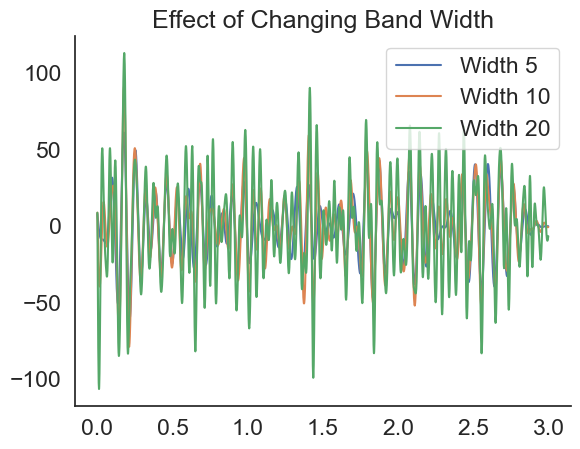

In [7]:
# Changing the width of the band
for width in [5, 10, 20]:
    filtered_signal = bandpass_filter(signal[:fs*3], 10, 10+width, fs, order)
    plt.plot(time[:fs*3], filtered_signal, label=f'Width {width}')

plt.legend()
plt.title('Effect of Changing Band Width')
plt.show()


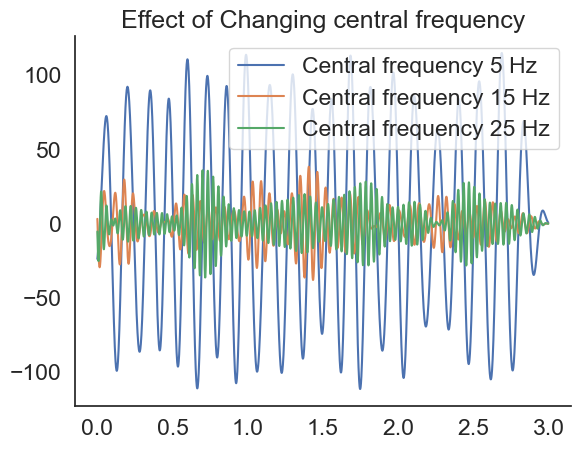

In [8]:
# effect of changing the central frequency
for central_freq in [5, 15, 25]:
    filtered_signal = bandpass_filter(signal[:fs*3], central_freq, central_freq+5, fs, order)
    plt.plot(time[:fs*3], filtered_signal, label=f'Central frequency {central_freq} Hz')

plt.legend()
plt.title('Effect of Changing central frequency')
plt.show()

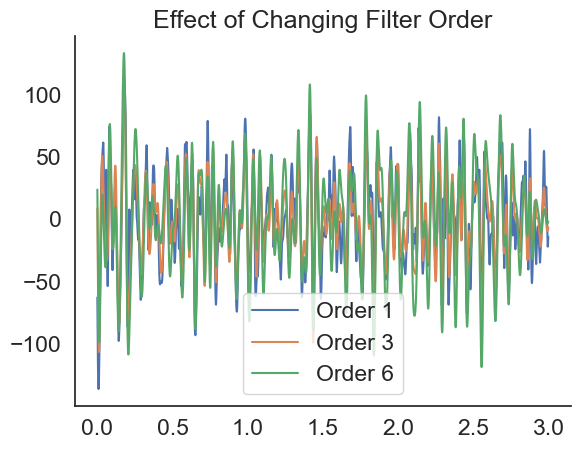

In [9]:
# effect of changing the filter order
for order in [1, 3, 6]:
    filtered_signal = bandpass_filter(signal[:fs*3], 10, 30, fs, order)
    plt.plot(time[:fs*3], filtered_signal, label=f'Order {order}')
    

plt.legend()
plt.title('Effect of Changing Filter Order')
plt.show()

244 µs ± 9.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
272 µs ± 4.44 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
329 µs ± 3.85 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


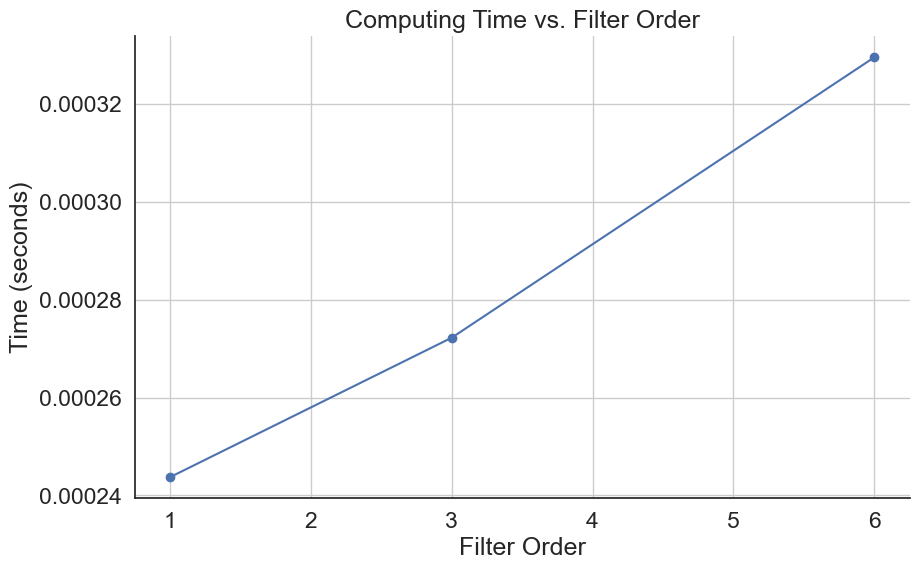

In [22]:
# quantifying computing time

# prepare lists to store results
orders = []
times = []

# Capture timing for each order using %timeit
for order in [1, 3, 6]:
    timing_result = %timeit -o bandpass_filter(signal[:fs*3], 10, 30, fs, order)
    orders.append(order)
    times.append(timing_result.average)  # Store the average time
    
plt.figure(figsize=(10, 6))
plt.plot(orders, times, marker='o')
plt.title('Computing Time vs. Filter Order')
plt.xlabel('Filter Order')
plt.ylabel('Time (seconds)')
plt.grid(True)
plt.show()

# computing time increases with higher filter orders


Exercise 2: wavelet transform with real wavelets

In [29]:
from scipy import signal
from pywt import scale2frequency
from pywt import cwt

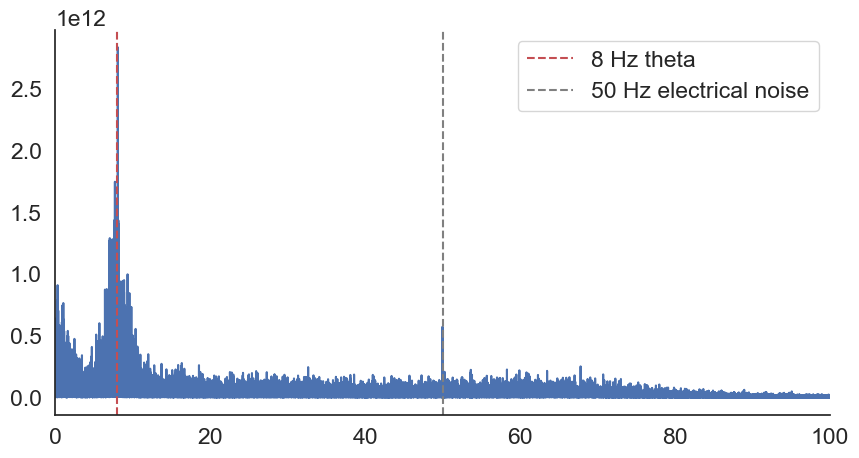

In [28]:
from scipy.fft import fft, fftfreq

n_samples = len(lfp)
sample_dt = 1. / sampling_rate

# we subtract the mean to get rid of the 0 frequency component in the spectrum
centered_lfp = lfp - np.mean(lfp)

transformed_signal = fft(centered_lfp) 

frequencies = fftfreq(n_samples,sample_dt) 

transformed_signal = transformed_signal[:n_samples//2]
frequencies = frequencies[:n_samples//2]

power = abs(transformed_signal)**2

plt.figure(figsize = (10,5))
plt.plot(frequencies,power)
plt.xlim([0,100]) # restrict to 
plt.axvline(x=8 ,c='r',linestyle='--',label='8 Hz theta')
plt.axvline(x=50 ,c='grey',linestyle='--',label='50 Hz electrical noise')

plt.legend()

In [30]:
from ipywidgets import interact
import ipywidgets as widgets


def plot_wavelet(scale,freq):
    plt.figure(figsize=(10,5))
    wavelet = signal.morlet(1000,s=scale,w=freq)
    envelope = abs(wavelet)
    plt.plot(wavelet.real,label='wavelet (real part)')
    plt.plot(envelope, label = 'envelope')
    plt.legend(loc=[1,1])
    plt.axis('off')

interact(plot_wavelet, scale = widgets.FloatSlider(min=.05, max=2, value=.5),
                       freq = widgets.FloatSlider(min=1, max=20, value=5))

interactive(children=(FloatSlider(value=0.5, description='scale', max=2.0, min=0.05), FloatSlider(value=5.0, d…

<function __main__.plot_wavelet(scale, freq)>

Text(0, 0.5, 'power (a.u.)')

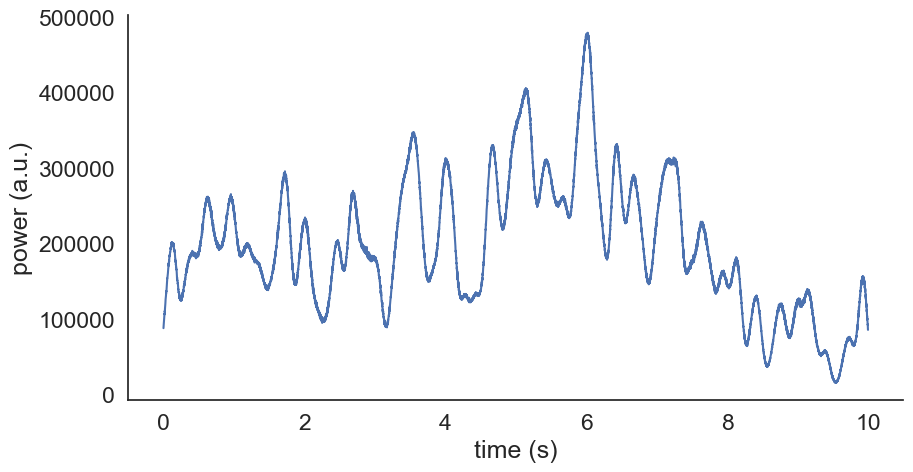

In [31]:
start = 0 #in seconds
end = 10 # in seconds

sig = lfp[int(start*sampling_rate):int(end*sampling_rate)]
sig = sig - np.mean(sig) # get rid of 0 frequency component

frequencies =  np.linspace(6,10,50)/sampling_rate
wavelet = 'cmor1.0-1.0'
scales = scale2frequency(wavelet, frequencies)
cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0/sampling_rate)

power = np.mean(abs(cwtmatr)**2,axis=0)

plt.figure(figsize=(10,5))
plt.plot(np.linspace(start,end,len(power)),power)
plt.xlabel('time (s)')
plt.ylabel('power (a.u.)')

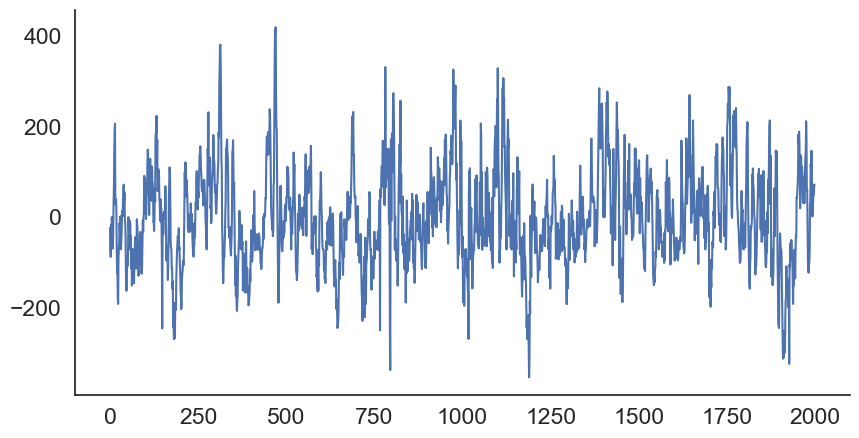

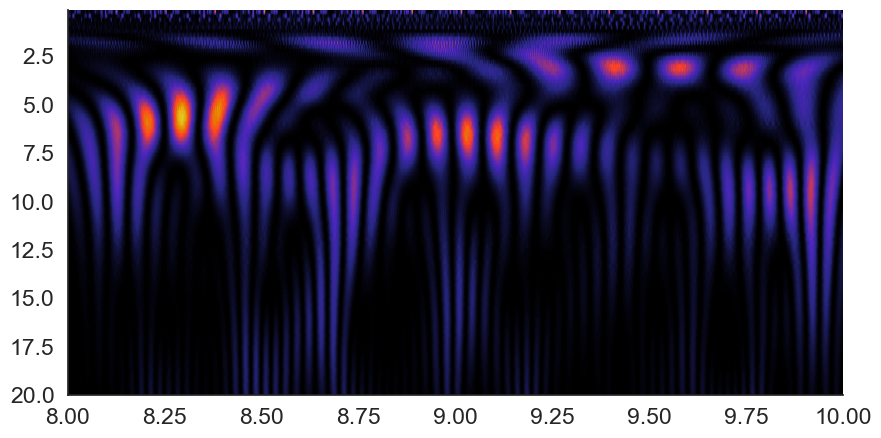

In [49]:
from pywt import scale2frequency
from pywt import cwt

start = 8 #in seconds
end = 10 # in seconds

sig = lfp[int(start*sampling_rate):int(end*sampling_rate)]
sig = sig - np.mean(sig) # get rid of 0 frequency component

plt.figure(figsize=(10,5))
plt.plot(sig)

#spectrogram with morlet transform

frequencies =  np.linspace(0.1,20,100)/sampling_rate
wavelet = 'morl'
scales = scale2frequency(wavelet, frequencies)
cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0/sampling_rate)
plt.figure(figsize=(10,5))
plt.imshow(abs(cwtmatr)**2, extent=[start,end,frequencies[-1]*sampling_rate,
                         frequencies[0]*sampling_rate], aspect='auto', cmap='CMRmap')

Text(0, 0.5, 'power (a.u.)')

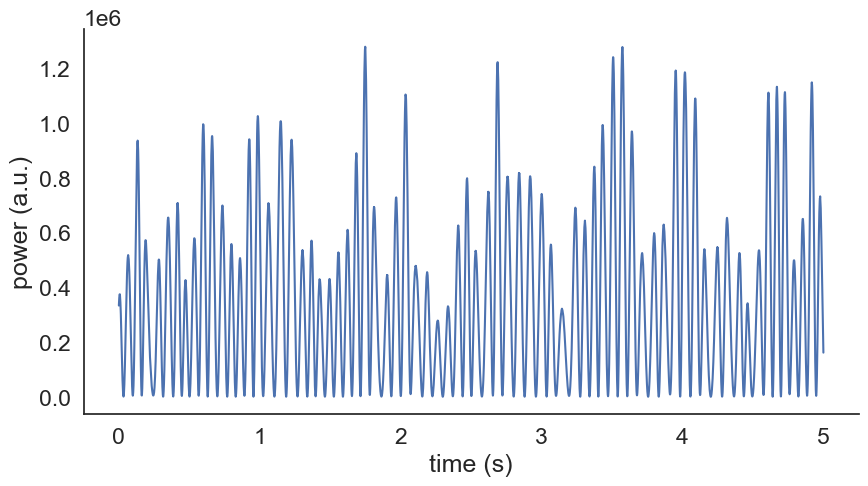

In [54]:
start = 0 #in seconds
end = 5 # in seconds

sig = lfp[int(start*sampling_rate):int(end*sampling_rate)]
sig = sig - np.mean(sig) # get rid of 0 frequency component

frequencies =  np.linspace(6,10,50)/sampling_rate
wavelet = 'mexh'
scales = scale2frequency(wavelet, frequencies)
cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0/sampling_rate)

power = np.mean(abs(cwtmatr)**2,axis=0)

plt.figure(figsize=(10,5))
plt.plot(np.linspace(start,end,len(power)),power)
plt.xlabel('time (s)')
plt.ylabel('power (a.u.)')

In [55]:
from scipy.signal import cwt, ricker, gaussian, morlet

# Wavelet functions
def apply_wavelet(data, wavelet, widths):
    return cwt(data, wavelet, widths)
# Wavelet parameters
widths = np.arange(1, 31)

# Applying different wavelets
ricker_wavelet = apply_wavelet(segment, ricker, widths)
morlet_wavelet = apply_wavelet(segment, morlet, widths)

# Plotting
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(ricker_wavelet), extent=[0, 1, 1, 31], cmap='PRGn', aspect='auto', vmax=abs(ricker_wavelet).max(), vmin=-abs(ricker_wavelet).max())
plt.title('Ricker Wavelet Transform')
plt.show()


ImportError: cannot import name 'gaussian' from 'scipy.signal' (C:\Users\Jelle\miniforge3\envs\neural_data\lib\site-packages\scipy\signal\__init__.py)